## 0. Install dependencies    

In [ ]:
!pip install -r requirements.txt

In [1]:
import opendatasets as od
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import tensorflow as tf
import xml.etree.ElementTree as ET
import os
import cv2
import random
import itertools
from glob import glob
from collections import Counter
from skimage.feature import hog
from skimage import exposure
from PIL import Image
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

##  1. Download data

**Download the dataset straight from the Kaggle using Kaggle API**

(for more information https://www.geeksforgeeks.org/how-to-download-kaggle-datasets-into-jupyter-notebook/)

In [6]:
od.download("https://www.kaggle.com/datasets/khlaifiabilel/military-aircraft-recognition-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tymofiij
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████| 1.13G/1.13G [16:51<00:00, 1.19MB/s]


## 2. Analyze data

### 2.1 Dataset structure
**The Military Aircraft Recognition dataset contains  collection of airplane images with different camera angles and quality. Dataset has 20 different types of military aircrafts. Images are labeled and each one may contain different types.<br>
<br>
The dataset consists of 3 folders:**
- Annotations:
    - Horizontal Bounding Boxes with 3842 xml files that describe types of planes in the picture and 2 points of a rectangle<br>
      that bound an aircraft 
    - Oriented Bounding Boxes with 3842 xml files that describe types of planes in the picture and 4 points of a rectangle<br>
      that bound an aircraft and its rotation angle (that is always 0)
<br>
<br>
- ImageSets:
    - Consists of 1 folder that has 2 txt files: test.txt (image numbers of test dataset) and train.txt (image numbers of train     dataset)
<br>
<br>
- JPEGImages has 3842 images of .jpg format that have differet shape (median width = 800 and height = 800) and even dimensions (usualy it's 3 and rarely 4)

**Analyzing amount of data, verifying format(whether all pictures are .jpg)**

In [2]:
def extract_numeric_part(filename):
    """
    extract_numeric_part helps to sort the files by extracting
    the numerical part so it can be sorted
    :param filename: filename of the folder. Has to contain "/" and not "\"
    :return: digits of the filename
    """ 
    filename = filename.split('/')
    return int(''.join(filter(str.isdigit, filename[-1])))


annotations_horizontal_boxes = os.listdir('military-aircraft-recognition-dataset/Annotations/Horizontal Bounding Boxes/')
annotations_oriented_boxes = os.listdir("military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/")
images = os.listdir("military-aircraft-recognition-dataset/JPEGImages/")
print(f"Total amount of files in Horizontal Bounding Boxes:{len(annotations_horizontal_boxes)}")
print(f"Total amount of files in Oriented Bounding Boxes:{len(annotations_oriented_boxes)}")
print(f"Total amount of files in JPEGImages:{len(images)}")
                    
annotations_horizontal_boxes = sorted(glob("military-aircraft-recognition-dataset/Annotations/Horizontal Bounding Boxes/*.xml"), key=extract_numeric_part)
annotations_oriented_boxes = sorted(glob("military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/*.xml"), key=extract_numeric_part)
images = sorted(glob("military-aircraft-recognition-dataset/JPEGImages/*.jpg"), key=extract_numeric_part)

print(f"XML files in Horizontal Bounding Boxes:{len(annotations_horizontal_boxes)}")
print(f"XML files in Oriented Bounding Boxes:{len(annotations_oriented_boxes)}")
print(f"JPG files in JPEGImages:{len(annotations_oriented_boxes)}")

Total amount of files in Horizontal Bounding Boxes:3842
Total amount of files in Oriented Bounding Boxes:3842
Total amount of files in JPEGImages:3842
XML files in Horizontal Bounding Boxes:3842
XML files in Oriented Bounding Boxes:3842
JPG files in JPEGImages:3842


**Analyzing if there are any notation with an angle > 0**

In [3]:
found = 0
for xml_file in annotations_oriented_boxes:
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for object_element in root.findall('.//object'):
        name_element = object_element.find('name')
        robndbox_element = object_element.find('robndbox')
        if name_element is not None and robndbox_element is not None:
            angle = int(object_element.find('angle').text)
            if angle!=0:
                print(xml_file)
                found += 1
print(f"Amount of rotated boxes:{found}")

Amount of rotated boxes:0


**Show frequency histogram of picture size + analyze dimensions**

In [4]:
sizes = []
for image in images:
    image = plt.imread(image)
    sizes.append(image.shape)

In [5]:
widths = [shape[0] for shape in sizes]
heights = [shape[1] for shape in sizes]
dimensions = [shape[2] for shape in sizes]

width_counts = dict(zip(*np.unique(widths, return_counts=True)))
height_counts = dict(zip(*np.unique(heights, return_counts=True)))
dimension_counts = dict(zip(*np.unique(dimensions, return_counts=True)))

In [6]:
width_median = np.median(widths)
height_median = np.median(heights)
dimension_median = np.median(dimensions)

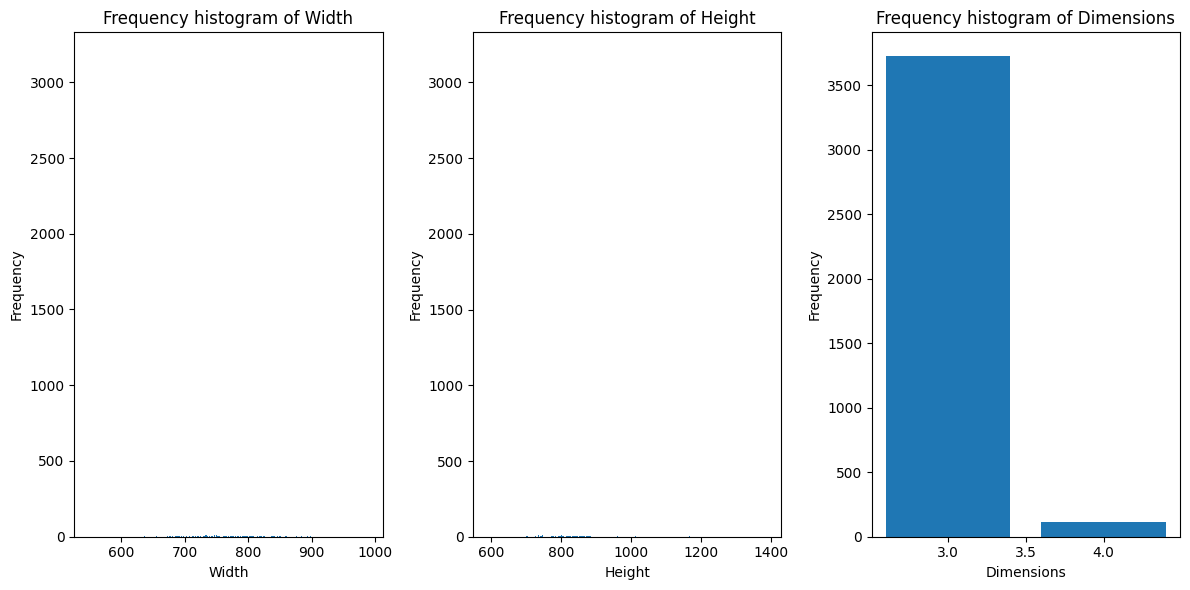

Median Width: 800.0
Median Height: 800.0
Median Dimensions: 3.0


In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.bar(width_counts.keys(), width_counts.values())
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Frequency histogram of Width')

plt.subplot(132)
plt.bar(height_counts.keys(), height_counts.values())
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Frequency histogram of Height')

plt.subplot(133)
plt.bar(dimension_counts.keys(), dimension_counts.values())
plt.xlabel('Dimensions')
plt.ylabel('Frequency')
plt.title('Frequency histogram of Dimensions')

plt.tight_layout()
plt.show()

print(f"Median Width: {width_median}")
print(f"Median Height: {height_median}")
print(f"Median Dimensions: {dimension_median}")

**Analyze distribution of pixel values whether there is any pattern
<br>(conclusion: distributions are usualy bimodal)**

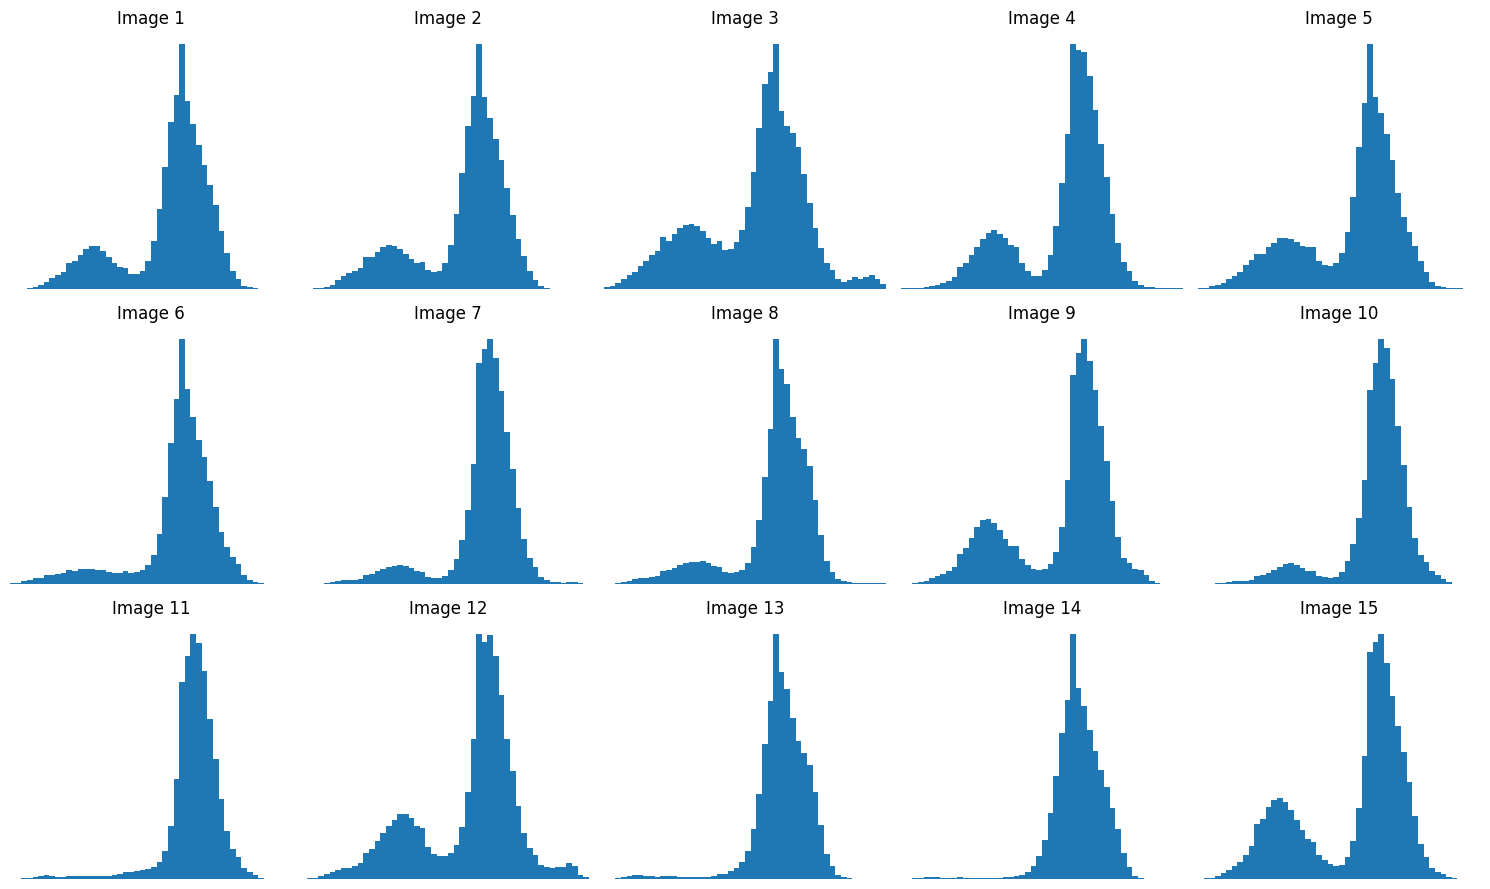

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

pixel_distributions = [plt.imread(images[i]) for i in range(15)]

fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for i, ax in enumerate(axes.ravel()):
    if i < len(pixel_distributions):
        img = pixel_distributions[i]
        
        pd.Series(img.flatten()).plot(kind="hist", bins=50, ax=ax)
        ax.set_title(f"Image {i + 1}")
        ax.set_xlim([0, 255])
        ax.axis('off')

plt.tight_layout()
plt.show()


### 2.2 Training and test sets distribution
**Frequency of plane types in training and test sets distribution is counted and analyzed. The annotations horizontal boxes were selected since they are easier and faster to implement.
<br>
<br>
Having the results it was taken into consideration that train-test datasets should be swapped for better training if deep learning would be used (maybe use stratified train-test separation technique). There are 100+ up to 750+ images per type.**

In [9]:
def extract_obj(img_list, xml_list):
    """
    extract_obj crops out the planes out of picture
    and helps form the whole dataset
    :param img_list: list of paths of pictures
    :param xml_list: list of paths of xml files-notations(Horizontal Bounding Boxes)
    :return: list of tuple label(type of plane),image(array of pixels)
    """ 
    assert len(img_list) == len(xml_list), "length of image list needs to be equal to length of xml list"
    dataset = []
    for i in range(len(img_list)):
        
        image = cv2.imread(img_list[i]) 
        xml_file = xml_list[i]

        with open(xml_file, 'r') as file:
            tree = ET.parse(file)
            root = tree.getroot()
            for object_element in root.findall('.//object'):
                name_element = object_element.find('name')
                robndbox_element = object_element.find('bndbox')

                if name_element is not None and robndbox_element is not None:
                    label = name_element.text

                    x_left_bottom = int(robndbox_element.find('xmin').text)
                    y_left_bottom = int(robndbox_element.find('ymin').text)
                    x_right_top = int(robndbox_element.find('xmax').text)
                    y_right_top = int(robndbox_element.find('ymax').text)

                    cropped_image = image[(y_left_bottom):(y_right_top), (x_left_bottom):(x_right_top)]

                    dataset.append((label,cropped_image))
    return dataset

In [10]:
dataset = extract_obj(images, annotations_horizontal_boxes)

In [11]:
X_dataset = [dataset[i][1] for i in range(len(dataset))]
Y_dataset = [dataset[i][0] for i in range(len(dataset))]


In [18]:
def extract_file_distribution(distribution_path, annotations_horizontal_boxes, images):
    """
    extract_file_distribution gets type and image of all the planes from distribution
    by counting them from each xml file and extracting from images
    :param distribution_path: path of the distribution file that countains
    numbers of image files 
    :param annotations_horizontal_boxes: path of the xml files folder
    :param images: path of images files folder
    :return: list of tuple label(type of plane),image(array of pixels) of current distribution
    """ 
    with open(distribution_path, 'r') as file:
        numbers = [int(line.strip()) for line in file]
        img_list = [images[number-1] for number in numbers]
        xml_list = [annotations_horizontal_boxes[number-1] for number in numbers]
        
    return extract_obj(img_list, xml_list)

In [19]:
train_txt_path = 'military-aircraft-recognition-dataset/ImageSets/Main/train.txt'
test_txt_path = 'military-aircraft-recognition-dataset/ImageSets/Main/test.txt'

train_dataset = extract_file_distribution(train_txt_path, annotations_horizontal_boxes, images)
test_dataset = extract_file_distribution(test_txt_path, annotations_horizontal_boxes, images)


train_names = [train_dataset[i][0] for i in range(len(train_dataset))]
train_images = [train_dataset[i][1] for i in range(len(train_dataset))]
test_names = [test_dataset[i][0] for i in range(len(test_dataset))]
test_images = [test_dataset[i][1] for i in range(len(test_dataset))]

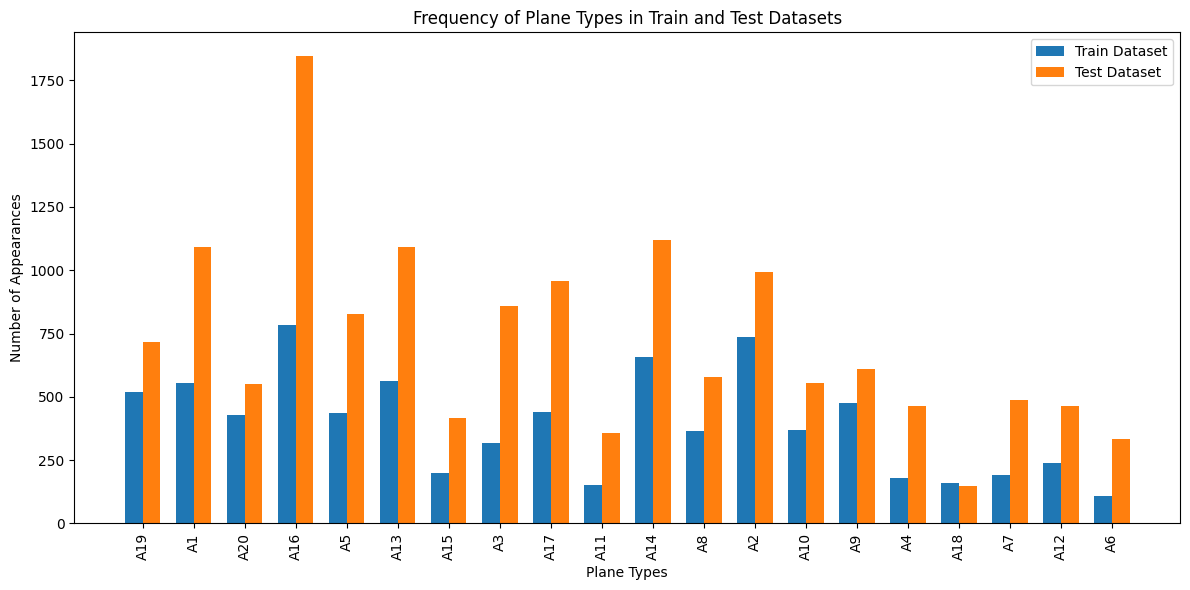

In [20]:
train_counter = Counter(train_names)
test_counter = Counter(test_names)

types = list(train_counter.keys())
train_counts = [train_counter[type] for type in types]
test_counts = [test_counter[type] for type in types]

plt.figure(figsize=(12, 6))
width = 0.35
x = range(len(types))

plt.bar(x, train_counts, width, label='Train Dataset')
plt.bar([i + width for i in x], test_counts, width, label='Test Dataset')

plt.xlabel('Plane Types')
plt.ylabel('Number of Appearances')
plt.title('Frequency of Plane Types in Train and Test Datasets')
plt.xticks([i + width/2 for i in x], types, rotation=90)  # Rotate x-axis labels for readability
plt.legend()
plt.tight_layout()

plt.show()

### 2.3 Data visualization
**Plot example of some images and experiment with them applying feature extraction techniques such as HOG and SIFT.
<br>In our case the color doesn't play crusial role so for the more effective work it is recomended to remove it and leave grayscale.**

(851, 816, 3)


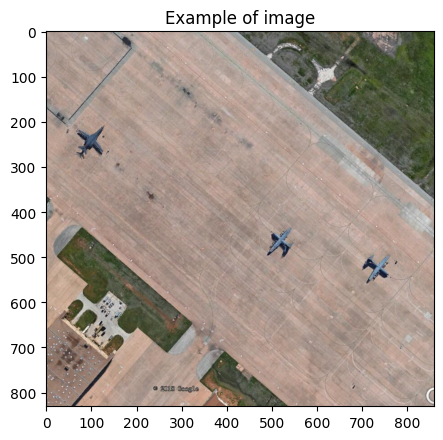

In [25]:
fig, ax = plt.subplots(figsize = (5,5))
ax.imshow(plt.imread(images[0]))
plt.title('Example of image')
print(img.shape)
plt.show()

#### HOG implementation

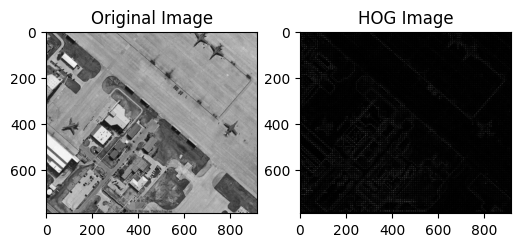

In [22]:
image = cv2.imread(images[2], cv2.IMREAD_GRAYSCALE)

features, hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

plt.figure(figsize=(6, 6))
plt.subplot(121)
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Original Image')

plt.subplot(122)
plt.imshow(hog_image, cmap=plt.cm.gray)
plt.title('HOG Image')

plt.show()

**Crop out the plane images**

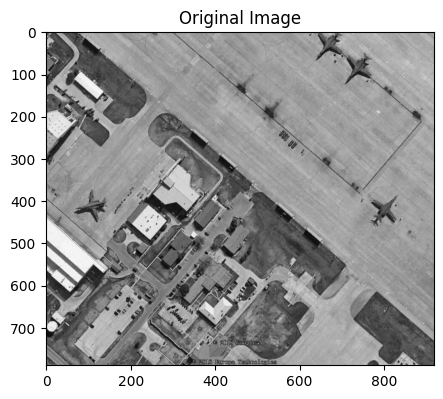

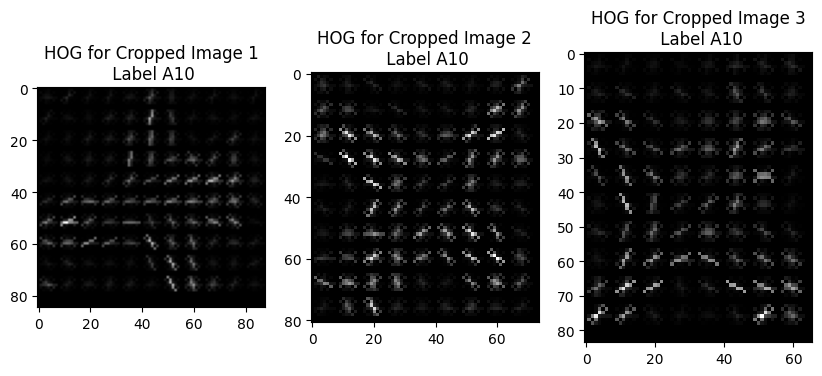

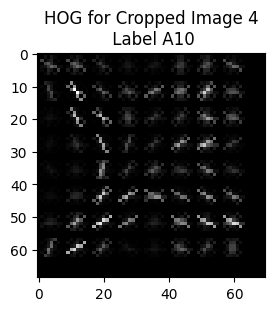

In [23]:
image = cv2.imread(images[2], cv2.IMREAD_GRAYSCALE)

xml_file = annotations_horizontal_boxes[2]
tree = ET.parse(xml_file)
root = tree.getroot()
cropped_images = []
for object_element in root.findall('.//object'):
    name_element = object_element.find('name')
    robndbox_element = object_element.find('bndbox')

    if name_element is not None and robndbox_element is not None:
        label = name_element.text

        x_left_bottom = int(robndbox_element.find('xmin').text)
        y_left_bottom = int(robndbox_element.find('ymin').text)
        x_right_top = int(robndbox_element.find('xmax').text)
        y_right_top = int(robndbox_element.find('ymax').text)

        cropped_region = image[y_left_bottom:y_right_top, x_left_bottom:x_right_top]

        cropped_images.append((label,cropped_region))
        
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Original Image')

for i in range(len(cropped_images)):
    if i % 3 == 0:
        # Create a new row of images every 3 images
        plt.figure(figsize=(10, 6))
    features, hog_image = hog(cropped_images[i][1], pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    plt.subplot(1, 3, i % 3 + 1)
    plt.title(f'HOG for Cropped Image {i + 1}\n Label {cropped_images[i][0]}')
    plt.imshow(hog_image, cmap=plt.cm.gray)
    if (i + 1) % 3 == 0 or (i + 1) == len(features):
        # Show the row of images when 3 images have been added or it's the last iteration
        plt.show()
        
plt.show()


#### Scale-Invariant Feature implementation

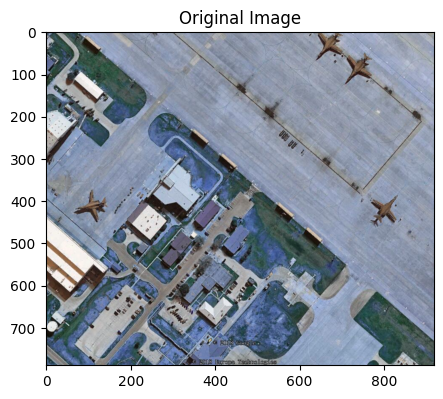

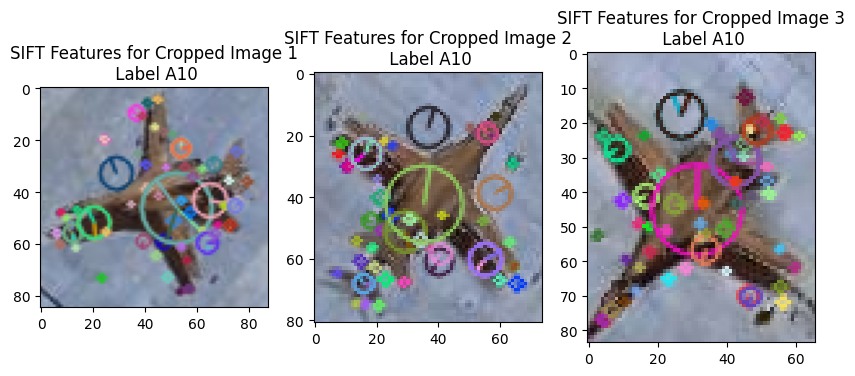

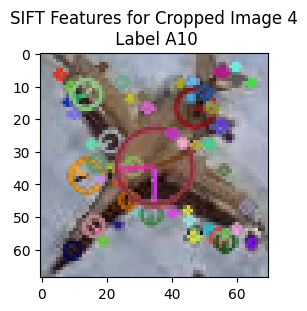

In [24]:
image = cv2.imread(images[2])


sift_features = []

xml_file = annotations_horizontal_boxes[2]
tree = ET.parse(xml_file)
root = tree.getroot()
cropped_images = []
for object_element in root.findall('.//object'):
    name_element = object_element.find('name')
    bndbox_element = object_element.find('bndbox')
    if name_element is not None and bndbox_element is not None:
        label = name_element.text
        x_left_top = int(bndbox_element.find('xmin').text)
        y_left_top = int(bndbox_element.find('ymin').text)
        x_right_bottom = int(bndbox_element.find('xmax').text)
        y_right_bottom = int(bndbox_element.find('ymax').text)

        cropped_region = image[y_left_top:y_right_bottom, x_left_top:x_right_bottom]

        sift = cv2.SIFT_create()

        key_points, descriptors = sift.detectAndCompute(cropped_region, None)

        sift_features.append((key_points, descriptors))   
        
        cropped_images.append((label,cropped_region))
        
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Original Image')

for i, (key_points, descriptors) in enumerate(sift_features):
    if i % 3 == 0:
        plt.figure(figsize=(10, 6))

    plt.subplot(1, 3, i % 3 + 1)
    plt.imshow(cropped_images[i][1], cmap=plt.cm.gray)
    plt.title(f'SIFT Features for Cropped Image {i + 1}\n Label {cropped_images[i][0]}')
    img_with_keypoints = cv2.drawKeypoints(cropped_images[i][1], key_points, outImage=cropped_images[i][1], flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_with_keypoints, cmap=plt.cm.gray)

    if (i + 1) % 3 == 0 or (i + 1) == len(sift_features):
        plt.show()

plt.show()



## 3. Further steps
**Having analyzed the dataset and applied feature extraction techniques such as HOG and SIFT the project is ready to begin ML part. First, implement ML classification model based on CNN, and then try to implement ML model based on HOG and SIFT. After classification is done we can start object detection part.**
<br> 
<br>
**First of all we need prepare the dataset:**
- Resize all images to a consistent size
- Normalize the pixel values
- Data augmentation


## 4. Dataset preparation
**As we discovered before, our data is not that clean and structured, so we need to prepare it for the future training, testing and usage of ML.**

### 4.1 Data split
**Create three sets (train, validation, and test) for ML model with existent train-test distribution from train.txt and test.txt files. As it was mentioned before it is recommended to swap training and test dataset since the last one has more instances of planes**

In [150]:
# Y_train,Y_test = test_names,train_names
# X_train,X_test = test_images,train_images

#lets experiment and mix all data together and then split it
X_train, X_test, Y_train, Y_test = train_test_split(X_dataset, Y_dataset, test_size=0.1, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

22341
18095
18095
2011
2011
2235
2235


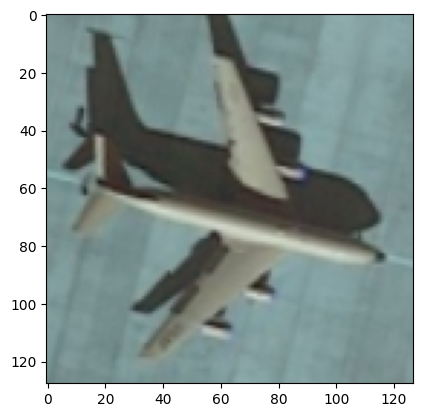

In [152]:
print(len(dataset))
print(len(X_train))
print(len(Y_train))
print(len(X_val))
print(len(Y_val))
print(len(X_test))
print(len(Y_test))
plt.imshow(X_train[0])


### 4.2 Standardizing dimensions
**Standardizing dimensions is a common preprocessing step in computer vision tasks to ensure that all images in our dataset have the same dimensions.**
<br> **Kaggle provides Dataset Notebooks where we can find other people experimenting with the dataset. Some of the ideas were inspired by NICKO REESE**
<br>https://www.kaggle.com/code/nickoreese/military-aircraft-recognition?scriptVersionId=143235915&cellId=9 

In [153]:
from PIL import Image
import numpy as np

def pad_img(img):
    '''
    pad_img transforms an image to the desired size.
    If squared, the image remains the same in ratio;
    if rectangular, it'll be padded evenly to become a squared one.

    :param img: A NumPy array representing the input image.
    :return: A NumPy array representing the transformed image.
    '''

    # Get the dimensions of the image
    old_size = img.shape[1], img.shape[0]
    # Define the desired size to transform the image to
    desired_size = (64, 64)

    # Calculate the maximum dimension of the original image
    max_dim = max(old_size)

    # Create a new image with the max_dim as the width and height
    padded = Image.new("RGB", (max_dim, max_dim))

    # Calculate the padding for the image to make it square
    x = (max_dim - old_size[0]) // 2
    y = (max_dim - old_size[1]) // 2

    # Paste the original image onto the padded image at the calculated position
    padded.paste(Image.fromarray(img), (x, y))

    # Resize the padded image to the desired size
    out_img = padded.resize(desired_size)
    # Convert the result back to a NumPy array
    out_img = np.array(out_img)

    # Return the transformed image as a NumPy array
    return out_img


In [154]:
X_train = [pad_img(X_train[i]) for i in range(len(X_train))]
X_test = [pad_img(X_test[i]) for i in range(len(X_test))]
X_val = [pad_img(X_val[i]) for i in range(len(X_val))]

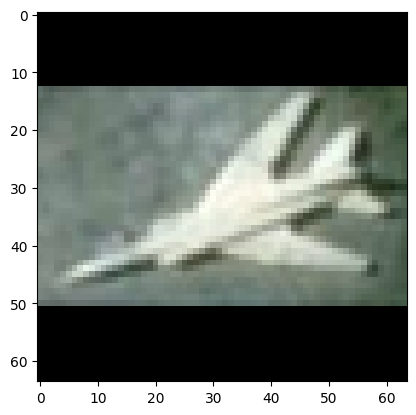

In [157]:
plt.imshow(X_val[1])

### 4.3 Normalize images and encode the labels
**Usage of one-hot encoding would be more profitable for our case.**
<br>https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd

In [158]:
categories = types

# Create a LabelBinarizer
label_binarizer = LabelBinarizer()
label_binarizer.fit(categories)

# Transform your dataset into one-hot encoded vectors
Y_train_encoded = label_binarizer.transform(Y_train)
Y_test_encoded = label_binarizer.transform(Y_test)
Y_val_encoded = label_binarizer.transform(Y_val)


**Normalize array of images**

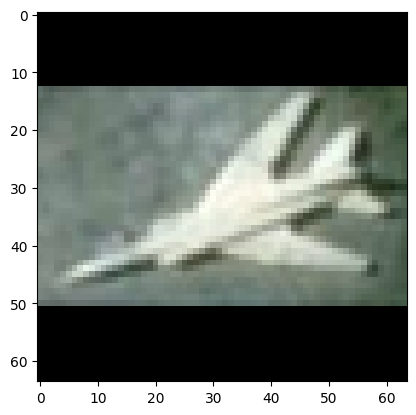

In [164]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

X_train_normalized = X_train / 255.0
X_val_normalized = X_val/ 255.0
X_test_normalized = X_test/ 255.0


X_train_filtered = np.array([img for img in X_train_normalized if img.ndim == 3])
X_val_filtered = np.array([img for img in X_val_normalized if img.ndim == 3])
X_test_filtered = np.array([img for img in X_test_normalized if img.ndim == 3])



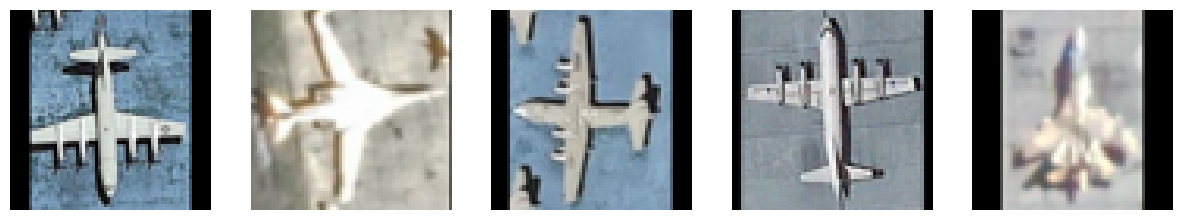

In [172]:
num_images = 5

# Randomly select `num_images` indices
random_indices = random.sample(range(len(X_train)), num_images)

# Create a subplot for displaying the images
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Display the random images
for i, index in enumerate(random_indices):
    axes[i].imshow(X_train_filtered[index], cmap='gray')
    axes[i].axis('off')

plt.show()

### 4.4 Data augmentation
**Use data augmentation in order to avoid overfitting**

In [171]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_datagen.fit(X_train_filtered)

train_generator = train_datagen.flow(X_train_filtered, Y_train_encoded)
validation_datagen = ImageDataGenerator(
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

validation_datagen.fit(X_val_filtered)

validation_generator = validation_datagen.flow(X_val_filtered, Y_val_encoded)

## 5. Creation of CNN ML model

### 5.1 Define constants

In [182]:
NUMBER_OF_CLASSES = len(types)
EPOCHS = 110
LEARNING_RATE = 0.005

### 5.2 Define the model-building function

In [183]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(16, (2, 2), activation='relu'),
        tf.keras.layers.AveragePooling2D(2, 2),
        tf.keras.layers.Conv2D(8, (2, 2), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax')
    ])

    # Use the Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,  
                  metrics=['accuracy'])

    return model


### 5.3 Train the model

In [184]:
# Create a new model
model = create_model()

#Train the model
history = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      verbose=1)

# history = model.fit(
#     X_train_filtered,  # Use X_train_filtered as your training data
#     Y_train_encoded,   # Use Y_train_encoded as the corresponding labels
#     batch_size=150,    # Specify the batch size
#     epochs=EPOCHS,     # Specify the number of epochs
#     validation_data=(X_val_filtered, Y_val_encoded),  # Use X_val_filtered and Y_val_encoded for validation
#     verbose=1
# )

Epoch 1/110
566/566 [==============================] - 37s 64ms/step - loss: 2.3423 - accuracy: 0.2511 - val_loss: 1.7936 - val_accuracy: 0.4088
Epoch 2/110
566/566 [==============================] - 42s 74ms/step - loss: 1.7984 - accuracy: 0.4062 - val_loss: 1.5731 - val_accuracy: 0.4769
Epoch 3/110
566/566 [==============================] - 47s 83ms/step - loss: 1.6209 - accuracy: 0.4632 - val_loss: 1.4118 - val_accuracy: 0.5182
Epoch 4/110
566/566 [==============================] - 39s 68ms/step - loss: 1.5141 - accuracy: 0.4900 - val_loss: 1.3433 - val_accuracy: 0.5559
Epoch 5/110
566/566 [==============================] - 46s 81ms/step - loss: 1.4425 - accuracy: 0.5119 - val_loss: 1.2967 - val_accuracy: 0.5704
Epoch 6/110
566/566 [==============================] - 37s 66ms/step - loss: 1.3871 - accuracy: 0.5406 - val_loss: 1.2663 - val_accuracy: 0.5788
Epoch 7/110
566/566 [==============================] - 44s 77ms/step - loss: 1.3531 - accuracy: 0.5489 - val_loss: 1.1247 - val_ac

### 5.4 Test the model

70/70 [==============================] - 1s 13ms/step


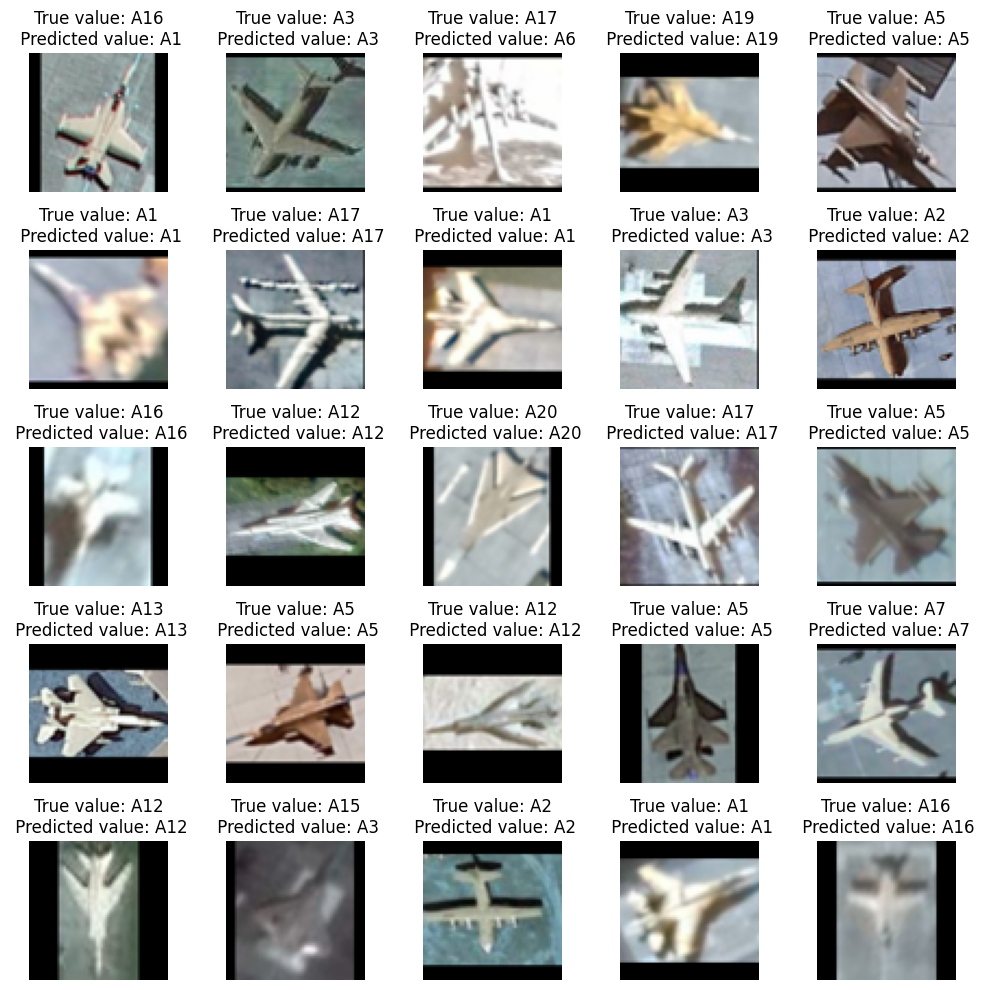

In [189]:
predictions = model.predict(X_test_filtered)

y_orig_true = label_binarizer.inverse_transform(Y_test_encoded)
y_orig_pred  = label_binarizer.inverse_transform(predictions)


fig, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.ravel()

random_numbers = []
for _ in range(25):
    random_number = random.randint(0, X_test.shape[0])
    random_numbers.append(random_number)
    
for i, rand in enumerate(random_numbers):
    axs[i].imshow(X_test[rand], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"True value: {y_orig_true[rand]}\n Predicted value: {y_orig_pred[rand]}")

plt.tight_layout()
plt.show()

### 5.5 Save the model

In [186]:
model_save_path = './trained_cnn_model'

# Save the model
model.save(model_save_path)

INFO:tensorflow:Assets written to: ./trained_cnn_model\assets


INFO:tensorflow:Assets written to: ./trained_cnn_model\assets
